In [4]:
import aslearn
from sklearn.datasets import fetch_openml
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

In [2]:
#Helper function to plot accuracy and loss as we train the model
def validation(dnn):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))


    e = [i for i in range(dnn.epochs)]

    ax1.set_title('Accuracy')
    ax1.plot(e, dnn.accuracy_history['Train'], label='Train')
    ax1.plot(e, dnn.accuracy_history['Test'], label='Test')
    ax1.legend()

    ax2.set_title('Loss')
    ax2.plot(e, dnn.J_history['J'])
    ax2.set_yscale('log')

    plt.suptitle('Validation')


    test_acc = dnn.accuracy_history['Test'][-1]
    train_acc = dnn.accuracy_history['Train'][-1]
    print(f'Train: {train_acc:.2%}\nTest: {test_acc:.2%}')

# Overview:
The goal of this project is to create a fully featured production quality machine learning library that has support for multiple machine learning models.
While there are multiple libraries already available, building one from the ground up will help me learn how the models work under the hood, and put into practice object orientated methodologies.

This workbook is mainly to test the functionality the library.

**aslearn** is the name of my toy ML library.  It is named aslearn in homage to scikit-learn (sklearn) replacing “sk” with my initials “as”-- very creative I know. As the name might suggest, aslearn been developed to function with a similar API to scikit-learn, with a few extra features that I thought would be interesting.  I have not looked at the scikit-learn source code or documentation for reference and have reversed engendered its functionality solely from memory, so some things may be a bit different.  Because aslearn is implemented completely in python using only the numpy library,  I have vectorized the math as much as I could with numpy to keep performance reasonable, but the main goal of the project is not bleeding edge performance.

# Glossary
This implementation has some built in functionality that can be accessed through the key word arguments.  Some of these functions are not available in other libraries so their use may not be intuitive at first.

**Kwarg Features:**
- **keep_best:** This is a 'poor-mans' early stopping.  The values of theta are stored for the lowest value of J during the training cycle.  After all epochs are completed, theta is replaced by the theta values corresponding to the lowest value of J.  This could lead to over-fitting however it seems to have helped performance and consistency in this case.
- **feature_scaling:** There is a built in feature scaling class which is accessible through a fit and transformed in the Utils class, the SGD Class has access to this.  When set to True, the training data is automatically scaled before being passed through.  The fitted scaler class is stored in the classifier and when the predict method is called, the input is automatically scaled using the stored values learned during training.  I find this method simplifies the processing pipeline.
- **shuffle:** Shuffle will shuffle the training data after each epoch.  Doing this helps keep descent smooth by randomizing the data that is presented in each batch.


**Terms:**

In this workbook I may refer to some terms by the Greek symbols that are used to notate them in the mathematical equations.
- **X:**  The matrix that holds the vectors of the training samples
- **y:** The vector that holds the class identities for the vectors in X
- **alpha:** The learning rate term
- **theta:** the vector of model coefficients
- **J:** The cost.  Cost is a measure of error between a set of predictions and the corresponding true values 
- **Class, Target, Label:** Used somewhat interchangeable.  These are the distinct values found in y
- **llambda:** This refers to the lambda regularization term.  "Lambda" is reserved in python for anonymous functions, so an extra l is added on the front.  In off screen hyper-parameter tuning, overfitting did not seem to be a big issue, so regularization has been disabled.  This may be something worth tuning but for the sake of brevity we will not
- **n_epochs:** The amount of times the full dataset will be iterated over during training
- **batch_size:** The size of each set of training data that will be used to minimize J in relation to theta

# Methodology:
For the remainder of this workbook, I will work through solving the MNIST problem using a Fully Connected Deep Neural Network to showcase the functionality of the aslearn library, as well as the thought process for tackling this kind of problem.

# MNIST Dataset:
**MNIST** is a dataset of hand drawn numbers between Zero and Nine, as well as the labels for those digits.  It has been referred to as the "Hello World" of machine learning.  Because it is such a common dataset, it is a great place to start to make sure that the library is functioning correctly.

X Shape: 784
y Shape: 1
Samples: 70000
y Samples: ['5' '0' '4' '1' '9' '2' '1' '3' '1' '4' '3' '5' '3' '6' '1' '7']
X Samples (rendered):


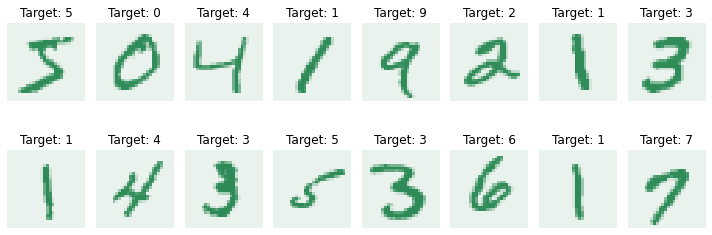

In [5]:
print(f'X Shape: {X.shape[1]}\ny Shape: {1}\nSamples: {len(y)}\ny Samples: {y[0:16]}\nX Samples (rendered):')

rows = 2
columns = 8
fig, axs = plt.subplots(rows,columns, figsize=(10, 4))
indx = 0
for i in range(rows):
    for j in range(columns):
        sample = X[indx]
        axs[i,j].imshow(np.reshape(X[indx], (28,28)), interpolation='nearest', cmap=sns.light_palette("seagreen", as_cmap=True))
        axs[i,j].axis('off')
        axs[i,j].autoscale(False)
        axs[i,j].title.set_text(f'Target: {y[indx]}')
        indx += 1
plt.tight_layout()
plt.show()

The version of MNIST we are using is already broken into X and y for us:

- **X:** The pixel values of the and written numbers.  They are unrolled into a single row vector with values between 0 and 255, representing white/black intensity.  
- **y:** A string value of the class names.  '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'

There are 70,000 samples for us to use.  We will begin by splitting them into 3 sets:

- **Train:** (60,000 samples) will be used in regression to fit the model parameters
- **Test:** (5,000 samples) Will be used to test the models and tweak hyper parameters
- **Validation:** (5,000 samples) Will be used for the final validation to gauge how the model will perform in the wild.  We use this because during training we will be using feedback from the Test set to make changes to the hyper-parameters, so the models will be somewhat fitted to the test set as a result.  Val will give a true sense of model performance.

**Feature Scaling and Reduction:**
 - We will fit a scaler to the X values to center and scale the data.  This will help with gradient descent.
 - We will fit a PCA model to reduce the features in X.  This will greatly reduce the amount of trainable parameters and greatly increase performance in training time and prediction times

**Encoding**

We will convert the y value from a single row of labels into vectors:
- '0' becomes [1,0,0,0,0,0,0,0,0,0]
- '1' becomes [0,1,0,0,0,0,0,0,0,0]
- '2' becomes [0,0,1,0,0,0,0,0,0,0]
- etc.

In [6]:
ohe = aslearn.Utils.One_Hot_Encoder()
scaler = aslearn.Utils.Scaler()
pca = aslearn.PCA()

train_samples = 60000


(X_train, y_train), (X_test, y_test) = aslearn.Utils.train_test_split(X, y, train_samples)

X_train = pca.fit_transform(X_train, features=.90, feature_scaling = True)
X_train = scaler.fit_transform(X_train)
y_train = ohe.fit_transform(y_train)


X_test = pca.transform(X_test)
X_test = scaler.transform(X_test)
y_test = ohe.transform(y_test)


test_val_samples = len(y_test) // 2
(X_test, y_test), (X_val, y_val) = aslearn.Utils.train_test_split(X_test, y_test, test_val_samples)

X_full = pca.transform(X)
X_full = scaler.fit_transform(X_full)
y_full = ohe.fit_transform(y)

print(f'X Features Reduced: {len(X[0])} ---> {len(X_train[0])}')
print(f'Y Encoding: {y[0]} ---> {y_train[0]}')

X Features Reduced: 784 ---> 64
Y Encoding: 5 ---> [0 0 0 0 0 1 0 0 0 0]


# Neural Network

Neural Networks are complex machine learning models that use multiple layers of nodes to propogate a signal up a network.
Each neuron accept's the outup of each of the nodes of the previous layer and multiplies them by a learned value (theta).  Theta is comprised of two components, the weights and biases.  Weights are multiplied to the outputs of the previous layer, then all the products are added together and finally the bias is added to the sum.  The final value is then passed through an activation function and fed forward to the next layer.

The values of theta are learned through a process called back propogation, where the error of the network is calculated and fed through all previous layers, updating theta along the way.

The input layer are the values from the training data, there are then some amount of hidden layers, and finaly an output layer.

## Output Layer
Output layer activation functions are dependant on the problem that is being solved, but most commonly it is:
- Softmax
- Sigmoid
- Linear

**Softmax:** Used for multi-class classification, or decision making
- Softmax activations force the sum of all the values of the nodes in the output layer to equal 1.  This can be used as a probability of confidance that the value the network is selecting is correct.
- Typically softmax outputs are passed through argmax to determine the final value of the output.

**Sigmoid:**
- Used for single-class classification
- Sigmoid will output a value between 0 and 1.  It is common to use sigmoid in a single node output to provide a probability for a given boolean value.  Typically a threshold is set to determine if the network produces a true or a false.

**Linear:**
- Used for regression problems with no fixed range of value for the output.

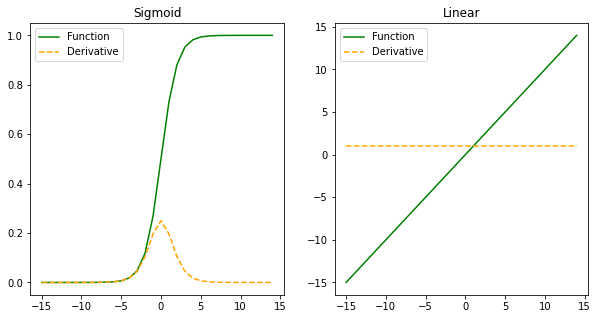

In [91]:
x_ = np.array([x for x in range(-15,15)])
af = aslearn.Activation_Functions

titles = ['Sigmoid', 'Linear']
gs = [af.sigmoid, af.linear]

fig, axs = plt.subplots(nrows=1, ncols=len(titles), figsize=(len(titles)*5,5))
for ax, g, title in zip(axs, gs, titles):
    ax.title.set_text(title)
    y_ = g(x_)
    ax.plot(x_, y_, 'g', label = 'Function')
    y_ = g(x_, derivative=True)
    ax.plot(x_, y_, color='orange', linestyle='dashed', label='Derivative')
    ax.legend()
plt.show()


## Hidden Layers
There are many different activation functions availible.  Typically it is common practice to use Rectified Linear Unit (ReLU) as it is able to reproduce the results of most other activation functions.  This is the default unless there is a very strong reason why you would choose another.

We will be using a version of ReLU called leaky ReLU.  It is very similar to a normal ReLU activation but has an advantage in that it doesn’t suffer from becoming inactive.

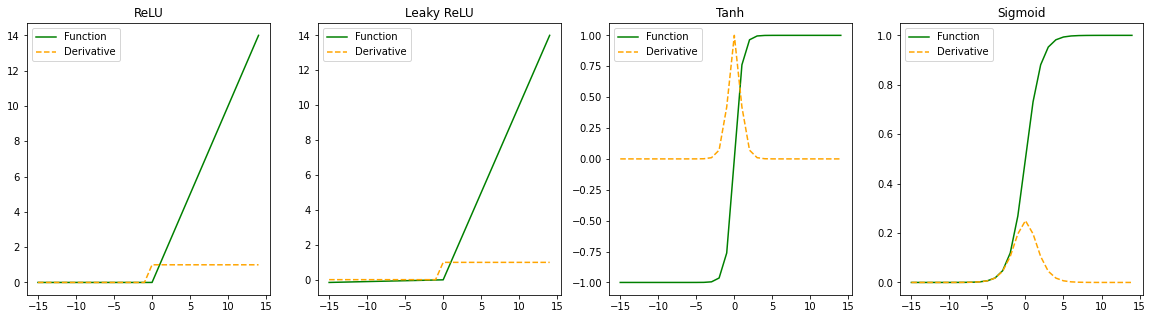

In [92]:
titles = ['ReLU', 'Leaky ReLU', 'Tanh', 'Sigmoid']
gs = [af.relu, af.leaky_relu, af.tanh, af.sigmoid]

fig, axs = plt.subplots(nrows=1, ncols=len(titles), figsize=(len(titles)*5,5))
for ax, g, title in zip(axs, gs, titles):
    ax.title.set_text(title)
    y_ = g(x_)
    ax.plot(x_, y_, 'g', label = 'Function')
    y_ = g(x_, derivative=True)
    ax.plot(x_, y_, color='orange', linestyle='dashed', label='Derivative')
    ax.legend()
plt.show()

# Hyper Parameters

After PCA we have 64 features in our training data.  Let’s start with a relatively simple model and try a single 16 node hidden layer into a softmax output with 10 nodes representing the classes in our y data.

We'll set batch size to 1024.  It is common practice to use powers of two when selecting batch size to optimize system resources.  This implementation is running on a CPU so there won’t be much difference, but we will follow the convention.

We'll run for 10 epochs just so we can check the curves and see how the model training is progressing.

We'll use default values for the rest of the hyper parameters:
- Alpha 0.01
- lambda 0

For a model with this configuration, the number of trainable parameters will be (64+1) * 16 + (16+1) * 10 = **1,210**

Each time that we want to predict a value, there will be 1,210 multiplications that happen, that is a lot of math under the hood!  If we did not use PCA to reduce the features of the input data then that number explodes:  (784+1) * 16 + (16+1) * 10 = **12,730**

Each one of these values also needs to be optimized during training.

In [7]:
dnn = aslearn.Neural_Network(config = [[16, 'leaky_relu'],[10, 'softmax']])

dnn.fit(X_train, y_train,
        X_test=X_test, y_test=y_test,
        epochs=10, batch_size = 1024,
        alpha = .06, llambda=0)

# Training Performance

Two major indicators of network training performance are Accuracy, and Loss.

**Accuracy**
- The percentage of how many samples the network correctly classified after each epoch.  It is calculated agains the training data that it is learning with, and the test data which the model has not been trained using.
- We should expect the test set to be less accurate than the train set, however if the accuracy is very far apart it would indicate overfitting

**Loss**
- Generally speaking this is the magnitude of the mistakes the network is making.  Even if it classifies correctly, the probability of the output may have been fairly uncertain.  Minimizing loss is the objective of back propgogation.

Train: 89.11%
Test: 87.46%


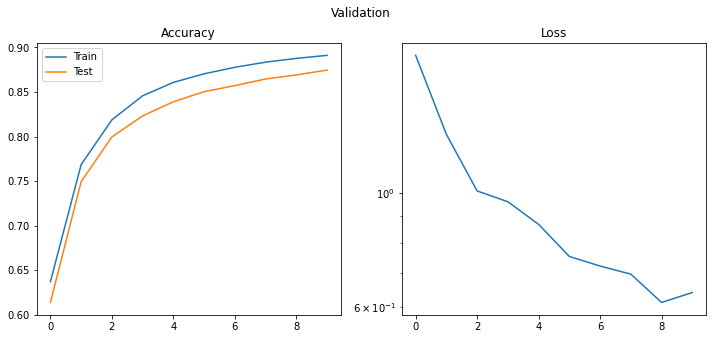

In [8]:
validation(dnn)

Using very standard hyper parameters, we already are around 87% accuracy.  This is great!  It looks like the increase to test accuracy has not flat lined either, let’s try training more and see if we can improve!

Train: 95.69%
Test: 94.22%


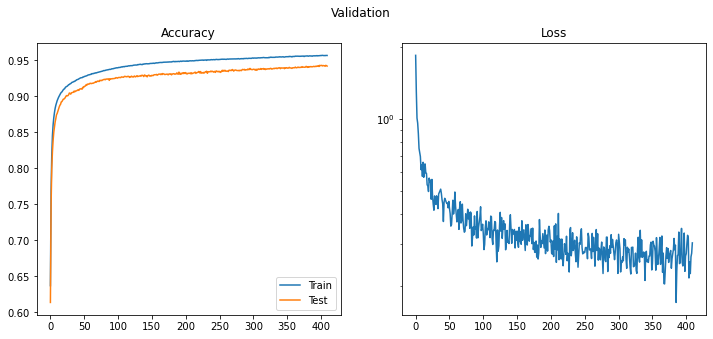

In [9]:
dnn.fit(X_train, y_train,
        X_test=X_test, y_test=y_test,
        epochs=400, batch_size = 1024,
        alpha = .06, llambda=0)

validation(dnn)

It looks like we've flatlined on improvements.  94% is really good though for a first attempt.  Lets try a more complicated model and see how it performs.

This time we will use two hidden layers, one with 128 nodes, and one with 64 nodes.

This will take much longer to train, remember that our previous model had 1,210 parameters to learn, now we have:  (64+1) * 128 + (128+1) * 64 + (64+1) * 10 = **17,226**

In [10]:
(64+1) * 128 + (128+1) * 64 + (64+1) * 10

17226

Because the model has so many parameters now, it will be a lot easier for it to overfit.  Overfitting is when the model memorizes the training data, and is able to give great accuracy on that, but when given the test data it hasnt seen before it fails to generalize.

For that reason, we'll use the lambda term which controls regularization.  Regularization adds a bit of error to the optimization during back propagation which prevents the model from over fitting.

Off Screen I have also tested the parameter of alpha and found 0.06 is a good value.  This was done by increasing the value of alpha by 3rds until the Accuracy and Loss curves show failure to converge.

alpha values = 0.01, 0.03, 0.06, 0.1, 0.3 ...

Train: 98.02%
Test: 96.02%


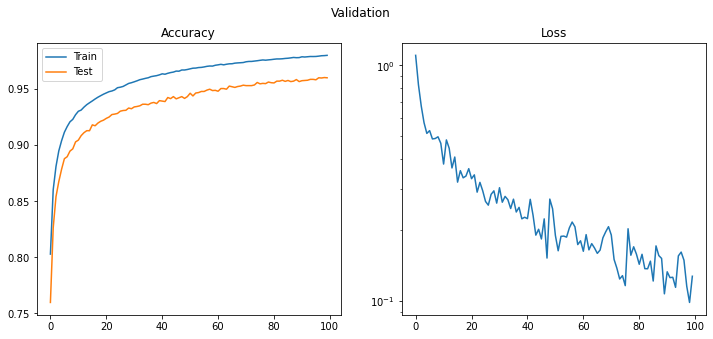

In [11]:
dnn = aslearn.Neural_Network(config = [[128, 'leaky_relu'],[64, 'leaky_relu'],[10, 'softmax']])

dnn.fit(X_train, y_train,
        X_test=X_test, y_test=y_test,
        epochs=100, batch_size = 1024,
        alpha = .06, llambda=0.001)

validation(dnn)

This is great, we're getting close to 96% accuracy on the test data.  The curves look like they're still increasing, and Loss is still decreasing.  Lets train some more and see if we can do even better!

Train: 99.80%
Test: 96.92%


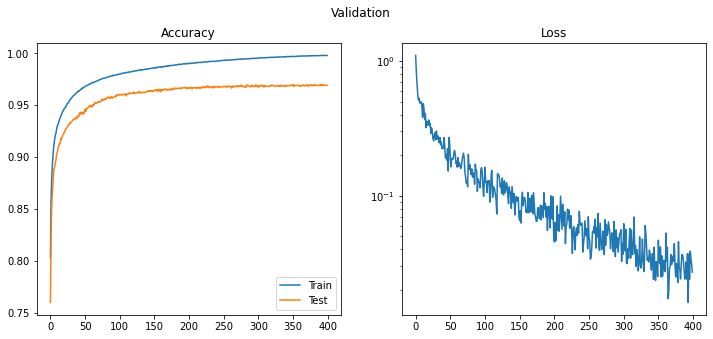

In [12]:
dnn.fit(X_train, y_train,
        X_test=X_test, y_test=y_test,
        epochs=300, batch_size = 1024,
        alpha = .06, llambda=0.001)
validation(dnn)

It looks like scores on the training data continue to improve and likely will reach 100% but the test accuracy has flattened out.  Some next steps would be:
 - Increasing lambda to try to prevent the gap between train and test accuracy from widening
 - Decrease Alpha to reduce the noise in the loss curve
 - Generate new training data by altering the existing data to give more variety

We also don’t know if the hyper parameters are the best possible to have been chosen.  Perhaps more, or larger hidden layers would help performance.  A common method to testing many hyper parameters would be a grid search where multiple combinations are tried systematically.  We will not be doing this in the example, but it would be a good follow-up in a real world scenario.

# Validation

The model has been trained using the training data so it will be fitted to that data.  We use the test data during training to adjust the hyper parameters of the model.  This can also cause a type of "meta" over fitting.  Before we started training, we set aside a validation set of data.  The network has never "seen" this data, and we have not used it to influence any decisions we made on selecting hyper parameters.

Now that we are done training, we will do one final test on this un-spoiled dataset to make sure our performance stays consistent, and we can have a good understanding of how the model will perform with 'wild' data.

We should expect the accuracy to be slightly worse than the test data accuracy.



In [13]:
pred = dnn.predict(X_val)
print(f'Accuracy: {sum(ohe.reverse_transform(y_val) == ohe.reverse_transform(pred)) / len(y_val):.2%}')
print(f'Incorrect: {len(y_val) - sum(ohe.reverse_transform(y_val) == ohe.reverse_transform(pred))}, Total: {len(y_val)}')

Accuracy: 98.86%
Incorrect: 57, Total: 5000


## Wow 98.86%

This is much better than the test data!  This is not typical or expected but is a welcome surprise.  It is likely an indicator that there are a bunch of difficult samples in the training data that is holding the model score down.  This is great news, as we can now deploy this model with confidence!